# GRF - examples 2D

Generate gaussian random fields (GRF) using fast Fourier transform (FFT).

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

## Define a covariance model in 2D: class `geone.covModel.covModel2D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

An azimuth angle, `alpha`, can be specified in degrees: the coordinates system Ox'y' supporting the axes of the model (ranges) is obtained from the original coordinates system Oxy by applying a rotation of `-alpha` (i.e. clockwise for positive angle).

In [2]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':5., 'r':[150, 40]}), # elementary contribution
    ('nugget', {'w':.5})                    # elementary contribution
    ], alpha=-30, name='model-2D example')

In [3]:
cov_model

Covariance model 2D: (Name = model-2D example)
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 5.0,  r = [150, 40]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angle: alpha = -30 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

### Plot the covariance / variogram function of the model

Plot the covariance function by using the method `plot_model` of the class. The following keyword arguments controls what is plotted:
- `plot_map`: `True` (default) or `False` indicating if the 2D-map is plotted
- `plot_curves`: `True` (default) or `False` indicating if curves of the function along axes x' and y' are plotted

If both are `plot_map` and `plot_curves` are set to `True` a new 1x2 figure is created (the size of the figure can be set with the keyword arguments `figsize` (tuple of 2 ints) and the keyword argument `show_suptitle` (`True` (default) or `False`) indicates if characteristics of the model is displayed as sup-title).

If only one of `plot_map` and `plot_curves` is set to `True`, the plot is done in the current figure axis.

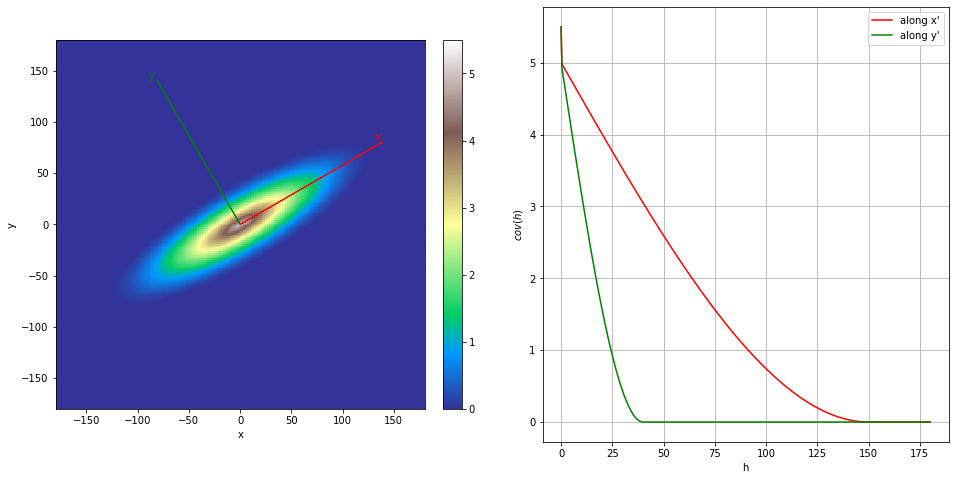

In [4]:
cov_model.plot_model(figsize=(16,8))
plt.suptitle('')
plt.show()

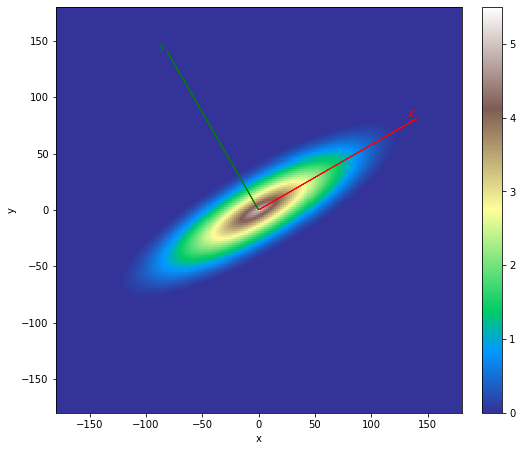

In [5]:
plt.figure(figsize=(8,8))
cov_model.plot_model(plot_curves=False)
plt.show()

Plot the variogram function. Same as above, but passing the keyword argument `vario=True` to the method `plot_model`.

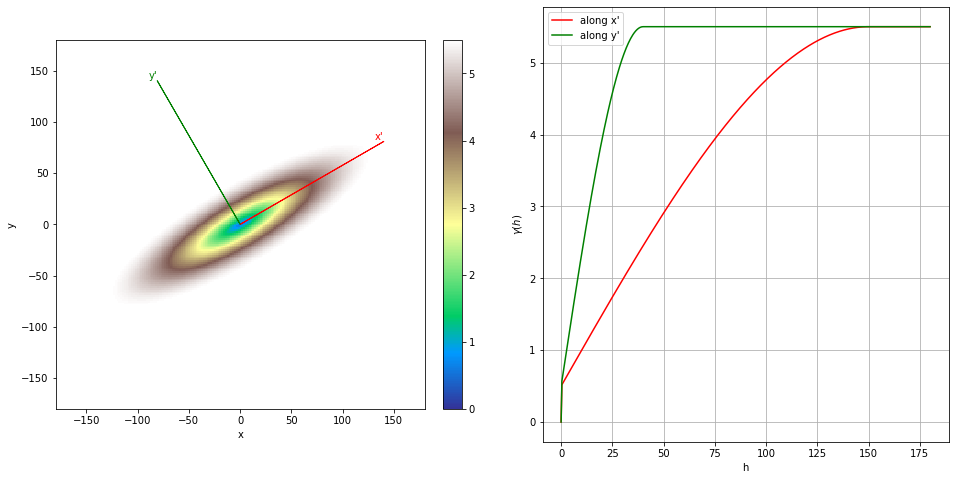

In [6]:
cov_model.plot_model(vario=True, figsize=(16,8))
plt.suptitle('')
plt.show()

The main axes x' and y' can be plotted using the method `plot_mrot`.

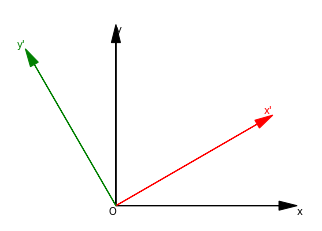

In [7]:
cov_model.plot_mrot()
plt.show()

Note that the colors used for the main axes (x' and y') can be changed in the figures above by passing the keyword arguments `color0` (axis x') and  `color1` (axis y').

### Get the sill and ranges

Get the sill and the range along each axis in the coordinates system supporting the axes of the model.

In [8]:
w = cov_model.sill() # scalar
r = cov_model.r12()  # vector (1d-array) of length 2: ranges along x', y'
print("Sill = {}".format(w))
print("Range along x' = {}, along y' = {}".format(r[0], r[1]))

Sill = 5.5
Range along x' = 150.0, along y' = 40.0


Get the maximal range along each axis of the original system Oxy.

In [9]:
rxy = cov_model.rxy()  # vector (1d-array) of length 2: "max ranges" along x, y
print("Max. range along x = {}, along y = {}".format(rxy[0], rxy[1]))

Max. range along x = 129.9038105676658, along y = 74.99999999999999


## Simulation of GRFs - 2D
Define the simulation grid.

In [10]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

### Remark
As the generation of GRFs is based on FFT, periodic fields are generated. Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `geone.grf.grf2D` based on the covariance model class passed as first argument. However, the minimal extension along each axis (x and y) can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (in the example below, the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` for each axis (i.e. `[geone.grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxy(), (nx, ny), (dx, dy))]`), and then passed to the GRF simulator `geone.grf.grf2D` via the keyword argument `extensionMin`.

#### Notes
When passing the covariance model class as first argument, the extension is computed based on the ranges of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the ranges will be multiplied by this factor before computing the extension.

### Unconditional simulations
Set the number of realizations, the seed and launch the (unconditional) simulations.

*Remark:* the keyword argument `printInfo` (`True` by default) can be set to `False` to not display information when running.

In [11]:
nreal = 500
np.random.seed(123)
# sim2Da = gn.grf.grf2D(cov_model, dimension, spacing, origin, nreal=nreal)
sim2Da = gn.grf.grf2D(cov_model, dimension, spacing, origin, nreal=nreal, printInfo=False)

The result is a 3d array of size `nreal` by `ny` by `nx`:

In [12]:
sim2Da.shape

(500, 230, 220)

Fill an image (`geone.img.Img` class) with all realizations (for display, see below), and delete the array sim2Da.

In [13]:
im2a = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim2Da)
del(sim2Da)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [14]:
im2a_mean = gn.img.imageContStat(im2a, op='mean') # pixel-wise mean
im2a_std = gn.img.imageContStat(im2a, op='std')   # pixel-wise standard deviation
# # Or:
# sim2Da_mean = np.mean(sim2Da.reshape(nreal, -1), axis=0).reshape(ny, nx)
# sim2Da_std = np.std(sim2Da.reshape(nreal, -1), axis=0).reshape(ny, nx)
# # and then fill new image with results

Plot the first realizations, the mean, and the standard deviation.

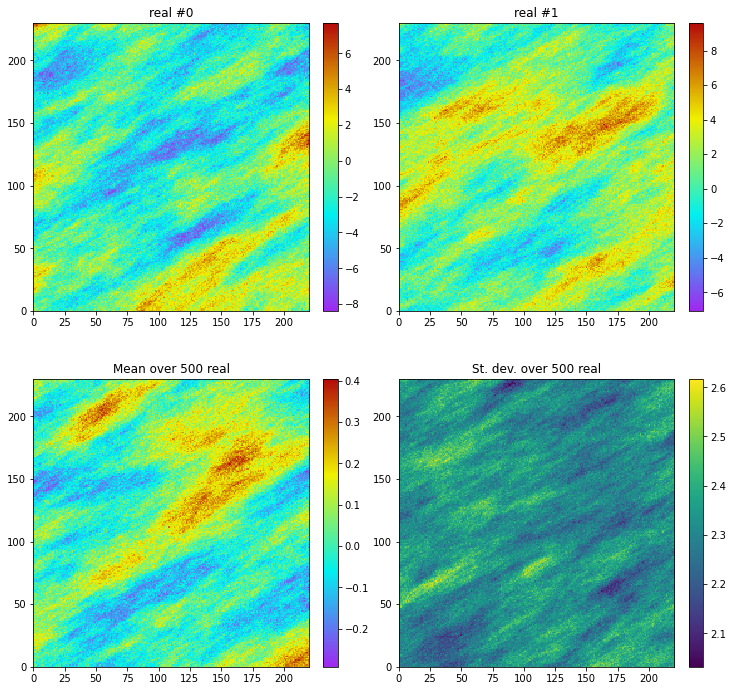

In [15]:
plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(im2a, iv=i)
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(im2a_mean)
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(im2a_std, cmap='viridis')
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

### Conditional simulations
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [16]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

Launch the simulations and plot.

In [17]:
nreal = 500
np.random.seed(123)
sim2Db = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im2b = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim2Db)
del(sim2Db)
im2b_mean = gn.img.imageContStat(im2b, op='mean') # pixel-wise mean
im2b_std = gn.img.imageContStat(im2b, op='std')   # pixel-wise standard deviation

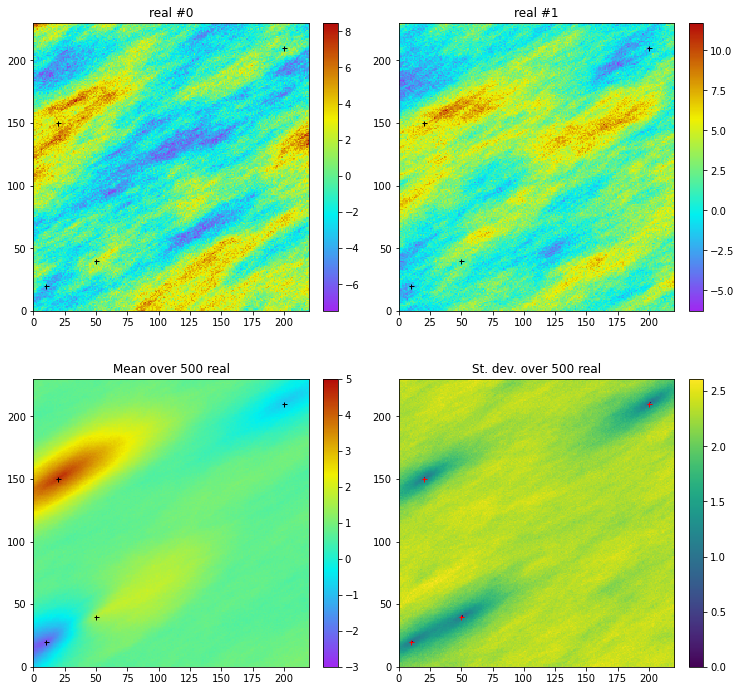

In [18]:
plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(im2b, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(im2b_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(im2b_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

### Kriging
Compute (simple) kriging estimates and standard deviation.

In [19]:
krig2Db, krig2Db_std = gn.grf.krige2D(x, v, cov_model, dimension, spacing, origin)

KRIGE2D: Computing circulant embedding...
KRIGE2D: Embedding dimension: 512 x 512
KRIGE2D: Computing FFT of circulant matrix...
KRIGE2D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE2D: Computing rBA * rAA^(-1)...
KRIGE2D: computing kriging estimates...
KRIGE2D: computing kriging standard deviation ...


Fill an image (Img class) with kriging estimates and standard deviation (for display, see below), and delete array krig2Db and krig2Db_std.

In [20]:
im2b_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((krig2Db, krig2Db_std)))
del(krig2Db, krig2Db_std)

Plot the kriging estimates and standard deviation.

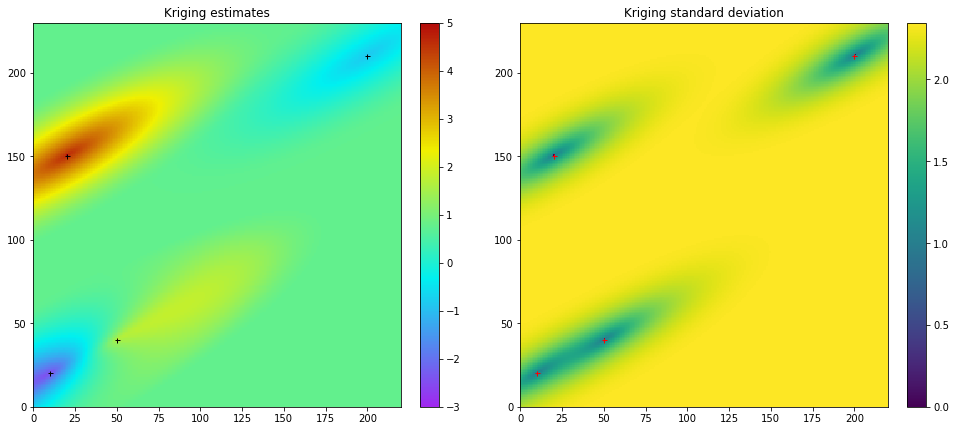

In [21]:
plt.subplots(1, 2, figsize=(16,8))

# kriging estimates
plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im2b_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im2b_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

### Comparison of mean and standard deviation of all realizations with kriging results

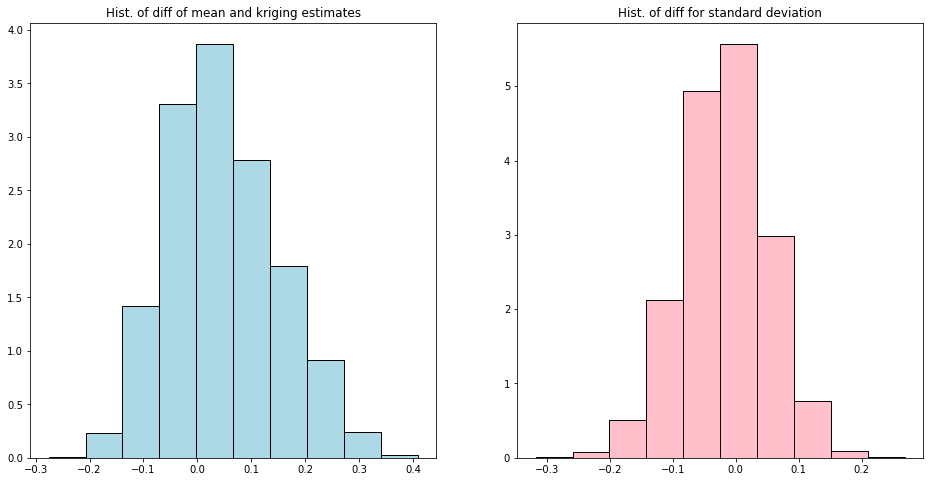

In [22]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im2b_mean.val.reshape(-1) - im2b_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im2b_std.val.reshape(-1) - im2b_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Simulations with imposed mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).

### Simulations with constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill.

In [23]:
nreal = 500
np.random.seed(123)
sim2Dc = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=3., var=2*cov_model.sill(), nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im2c = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim2Dc)
del(sim2Dc)
im2c_mean = gn.img.imageContStat(im2c, op='mean') # pixel-wise mean
im2c_std = gn.img.imageContStat(im2c, op='std')   # pixel-wise standard deviations

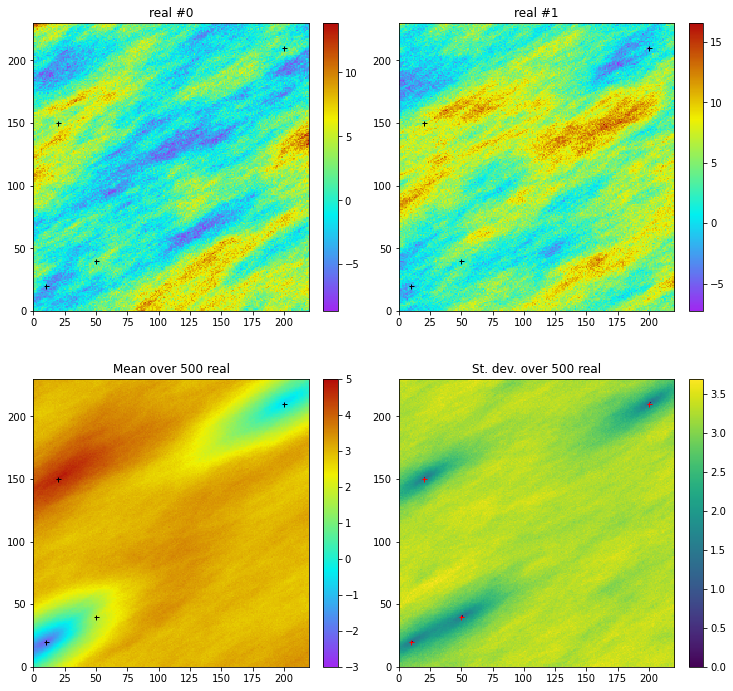

In [24]:
plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(im2c, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(im2c_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(im2c_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

In [25]:
krig2Dc, krig2Dc_std = gn.grf.krige2D(x, v, cov_model, dimension, spacing, origin, mean=3., var=2*cov_model.sill())

# Fill image with result
im2c_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((krig2Dc, krig2Dc_std)))
del(krig2Dc, krig2Dc_std)

KRIGE2D: Computing circulant embedding...
KRIGE2D: Embedding dimension: 512 x 512
KRIGE2D: Computing FFT of circulant matrix...
KRIGE2D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE2D: Computing rBA * rAA^(-1)...
KRIGE2D: computing kriging estimates...
KRIGE2D: computing kriging standard deviation ...


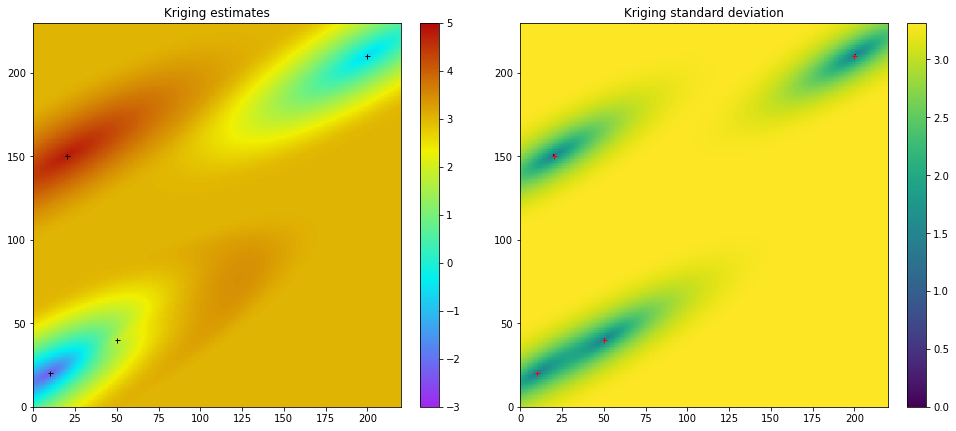

In [26]:
plt.subplots(1, 2, figsize=(16,8))

# kriging estimates
plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im2c_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im2c_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

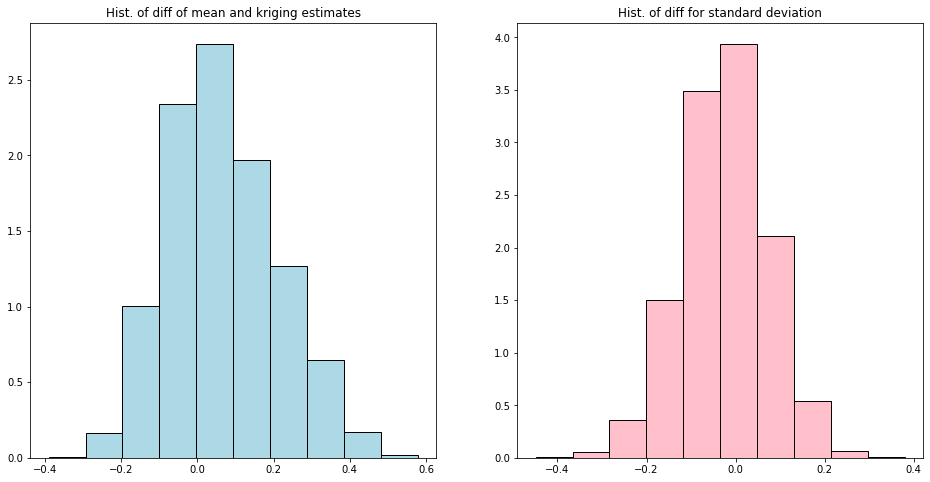

In [27]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im2c_mean.val.reshape(-1) - im2c_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im2c_std.val.reshape(-1) - im2c_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

### Simulations with non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

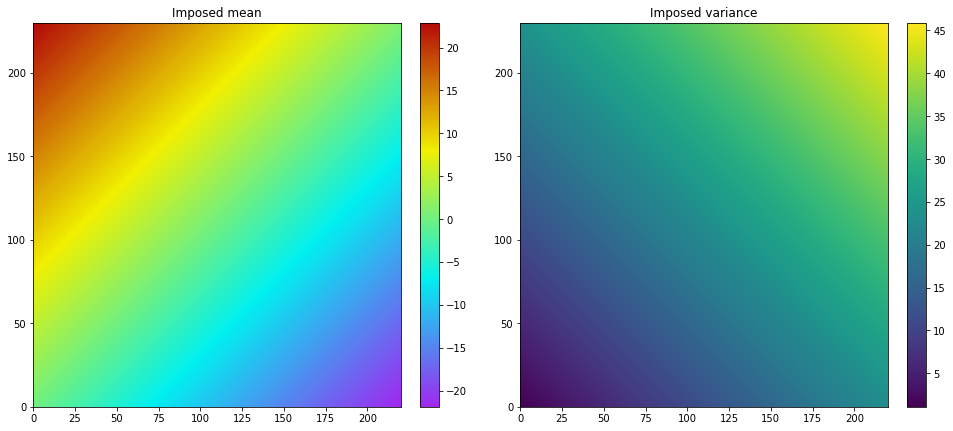

In [28]:
# Coordinates of the center of grid cells
xg = ox + dx*(0.5+np.arange(nx))
yg = oy + dy*(0.5+np.arange(ny))

# Create a meshgrid from the center of grid cells
xx, yy = np.meshgrid(xg, yg)

# Define the mean and variance on the simulation grid
mean = 0.1*(yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy)      # define variance on the simulation grid

# Fill image for display
im = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((mean, var)))

# Display imposed mean and var
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im, iv=0)
plt.title('Imposed mean')

plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im, iv=1, cmap='viridis')
plt.title('Imposed variance')

plt.show()

In [29]:
nreal = 500
np.random.seed(123)
sim2Dd = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=mean, var=var, nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im2d = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim2Dd)
del(sim2Dd)
im2d_mean = gn.img.imageContStat(im2d, op='mean') # pixel-wise mean
im2d_std = gn.img.imageContStat(im2d, op='std')   # pixel-wise standard deviations

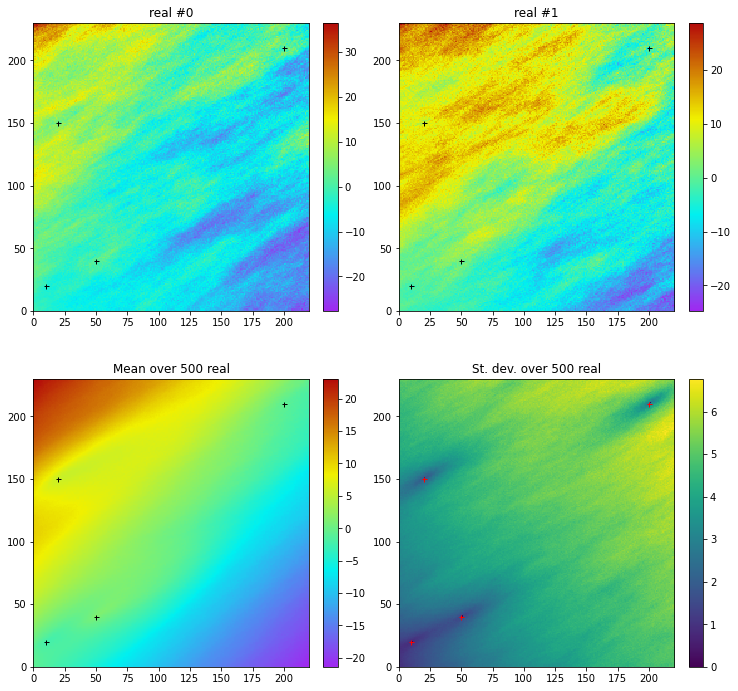

In [30]:
plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(im2d, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(im2d_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(im2d_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

In [31]:
krig2Dd, krig2Dd_std = gn.grf.krige2D(x, v, cov_model, dimension, spacing, origin, mean=mean, var=var)

# Fill image with result
im2d_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((krig2Dd, krig2Dd_std)))
del(krig2Dd, krig2Dd_std)

KRIGE2D: Computing circulant embedding...
KRIGE2D: Embedding dimension: 512 x 512
KRIGE2D: Computing FFT of circulant matrix...
KRIGE2D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE2D: Computing rBA * rAA^(-1)...
KRIGE2D: computing kriging estimates...
KRIGE2D: computing kriging standard deviation ...


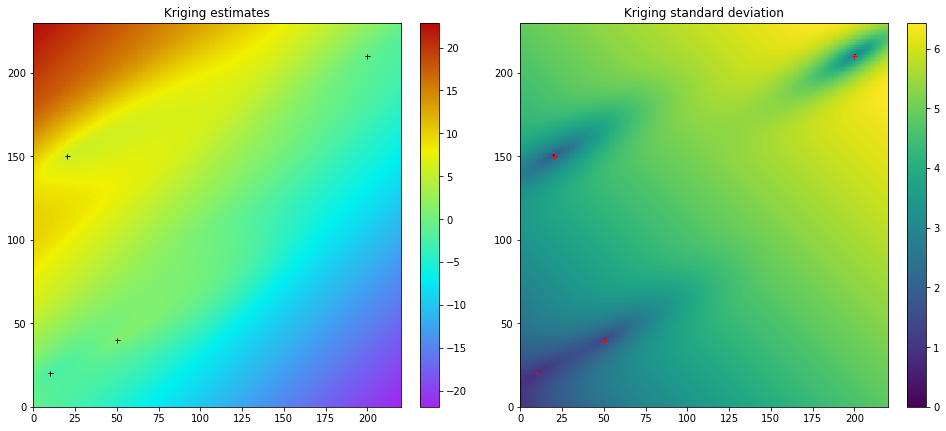

In [32]:
plt.subplots(1, 2, figsize=(16,8))

# kriging estimates
plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im2d_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im2d_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

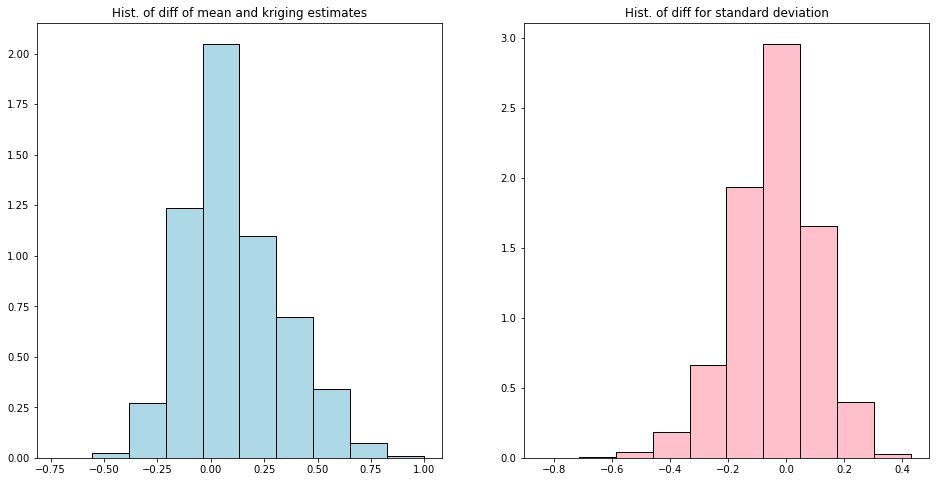

In [33]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im2d_mean.val.reshape(-1) - im2d_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im2d_std.val.reshape(-1) - im2d_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()